# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [2]:
import time
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb

from phik import phik_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [3]:
warnings.filterwarnings('ignore')

In [4]:
RANDOM_STATE = 0
TEST_SIZE = 0.25

## Подготовка данных

In [5]:
data = pd.read_csv('/datasets/autos.csv')

In [6]:
display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Описание данных**

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    Repaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя
**Целевой признак**

    Price — цена (евро)

In [8]:
data = data.rename(columns={
    'DateCrawled': 'date_crawled',
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'Gearbox': 'gearbox',
    'Power': 'power',
    'Model': 'model',
    'Kilometer': 'kilometer',
    'RegistrationMonth': 'registration_month',
    'FuelType': 'fuel_type',
    'Brand': 'brand',
    'Repaired': 'repaired',
    'DateCreated': 'date_created',
    'NumberOfPictures': 'number_of_pictures',
    'PostalCode': 'postal_code',
    'LastSeen': 'last_seen'
})

In [9]:
data.repaired = data.repaired.fillna('unknown')

In [10]:
data.vehicle_type = data.vehicle_type.astype('category')
data.gearbox = data.gearbox.astype('category')
data.fuel_type = data.fuel_type.astype('category')
data.brand = data.brand.astype('category')
data.repaired = data.repaired.astype('category')
data.date_created = pd.to_datetime(data.date_created)
data.date_crawled = pd.to_datetime(data.date_crawled)
data.last_seen = pd.to_datetime(data.last_seen)

In [11]:
data['date_crawled_date'] = data.date_crawled.dt.date
data['date_crawled_hour'] = data.date_crawled.dt.hour
data['date_crawled_year'] = data.date_crawled.dt.year
data['date_crawled_month'] = data.date_crawled.dt.month
data['date_created_year'] = data.date_created.dt.year
data['date_created_month'] = data.date_created.dt.month
data['last_seen_date'] = data.date_crawled.dt.date
data['last_seen_hour'] = data.date_crawled.dt.hour
data['last_seen_year'] = data.date_crawled.dt.year
data['last_seen_month'] = data.date_crawled.dt.month

data.date_crawled_date = pd.to_datetime(data.date_crawled_date)
data.last_seen_date = pd.to_datetime(data.last_seen)

In [12]:
data = data[(data['registration_year'] < 2021) & (data['registration_year'] > 1984)]
data = data[(data['power'] < 500) & (data['power'] > 50)]

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300204 entries, 1 to 354368
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        300204 non-null  datetime64[ns]
 1   price               300204 non-null  int64         
 2   vehicle_type        278655 non-null  category      
 3   registration_year   300204 non-null  int64         
 4   gearbox             294440 non-null  category      
 5   power               300204 non-null  int64         
 6   model               288246 non-null  object        
 7   kilometer           300204 non-null  int64         
 8   registration_month  300204 non-null  int64         
 9   fuel_type           280541 non-null  category      
 10  brand               300204 non-null  category      
 11  repaired            300204 non-null  category      
 12  date_created        300204 non-null  datetime64[ns]
 13  number_of_pictures  300204 no

In [14]:
print(data.count() / len(data))

date_crawled          1.000000
price                 1.000000
vehicle_type          0.928219
registration_year     1.000000
gearbox               0.980800
power                 1.000000
model                 0.960167
kilometer             1.000000
registration_month    1.000000
fuel_type             0.934501
brand                 1.000000
repaired              1.000000
date_created          1.000000
number_of_pictures    1.000000
postal_code           1.000000
last_seen             1.000000
date_crawled_date     1.000000
date_crawled_hour     1.000000
date_crawled_year     1.000000
date_crawled_month    1.000000
date_created_year     1.000000
date_created_month    1.000000
last_seen_date        1.000000
last_seen_hour        1.000000
last_seen_year        1.000000
last_seen_month       1.000000
dtype: float64


    Данные подготовлены, названия столбцов приведены к змеиному регистру, заполнены пропуски в одном столбце, удалены выбросы и добавлены новые столбцы со временем из дат

In [15]:
def pie_chart(data, column, **kwargs):
    data[column].value_counts().nlargest(20).plot(
        kind='pie',
        figsize=(10, 10),
        autopct='%1.1f%%',
        wedgeprops={'width': 0.5},
        ylabel='',
        **kwargs
    )
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right', fontsize=11)
    plt.show()

In [16]:
def hist_chart(data, column, **kwargs):
    data[column].plot(
        kind='hist',
        figsize=(10, 10),
        color='#BA55D3',
        **kwargs    
    )
    plt.axvline(x=data[column].mean(), color='red', linestyle='--', label='Mean value')
    plt.axvline(x=data[column].median(), color='green', linestyle='--', label='Median value')
    plt.legend()
    plt.show()

In [17]:
def boxplot_chart(data, column, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(10,10))
    sns.boxplot(
        x=column,
        data=data,
        ax=ax,
        palette=['#BA55D3'],
        flierprops={
            'marker': 'o',
            'markersize': 10,
            'markerfacecolor': 'blue',
            'markeredgecolor': 'black'
        }
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

In [18]:
def line_chart(data, index, values, aggfunc, **kwargs):
    data.pivot_table(
        index=index,
        values=values,
        aggfunc=aggfunc).plot(     
            style='o-',
            figsize=(10, 6),
            markerfacecolor='blue',
            markeredgecolor='black',
            markersize=8,
            linewidth=2,
            fontsize=14,
            **kwargs
        )
    
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Функции, которые понадобятся в проекте для отрисовки графиков

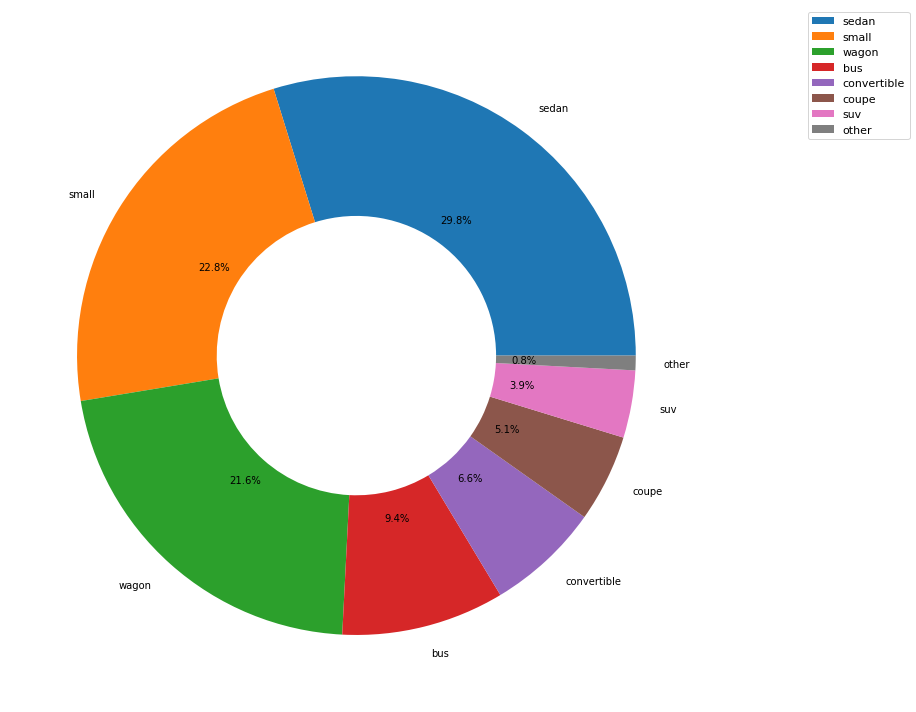

In [19]:
pie_chart(data, 'vehicle_type')

Самые популярные типы кузовов для продажи на сервисе:

    -sedan
    -small
    -wagon

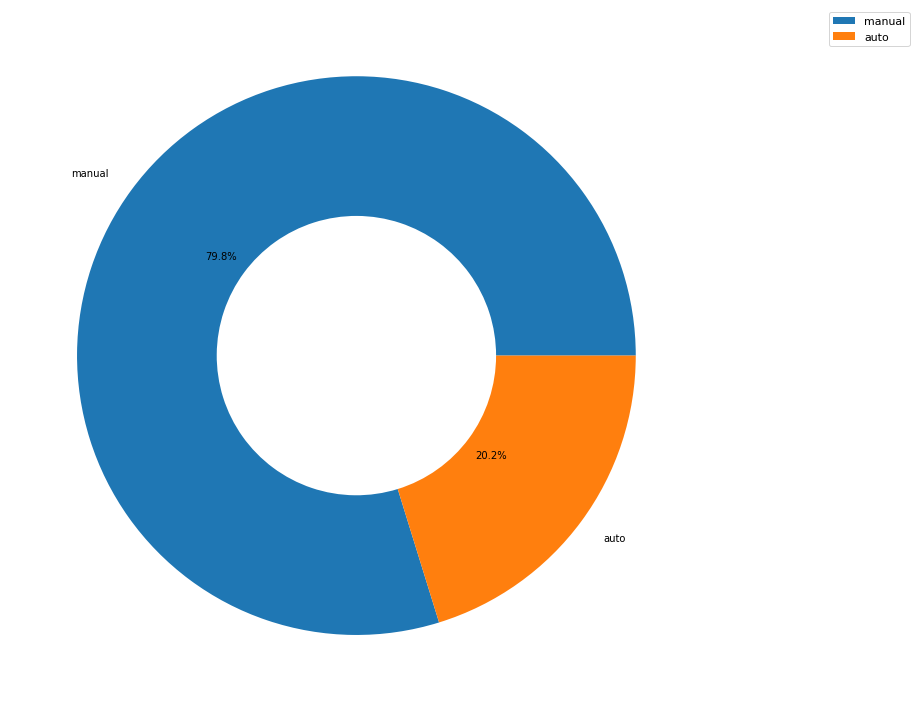

In [20]:
pie_chart(data, 'gearbox')

На сервисе больше всего машин с механической коробой передач - 81.5%

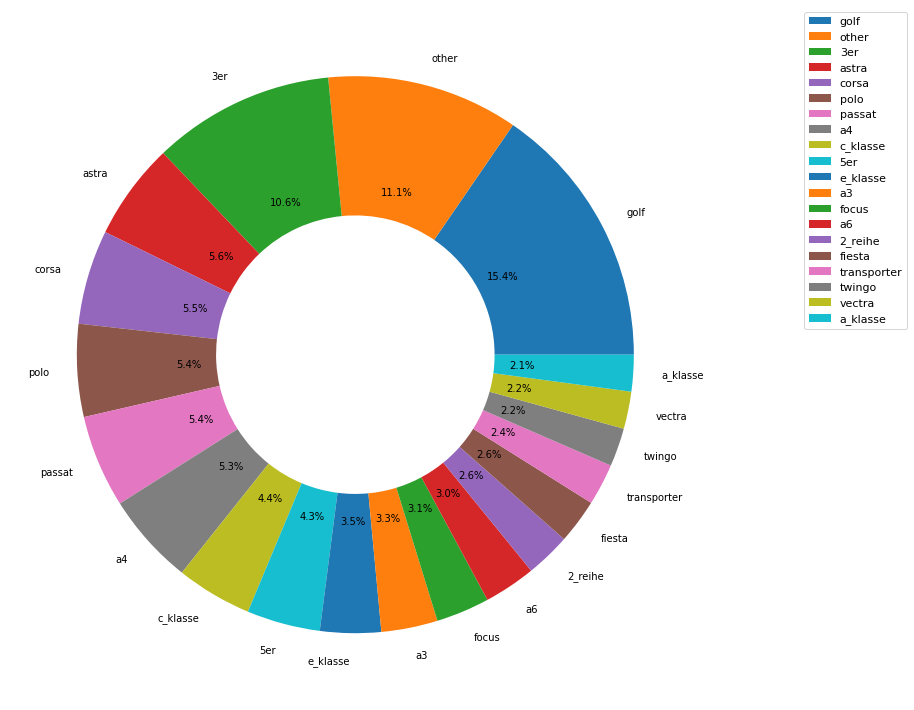

In [21]:
pie_chart(data, 'model')

Самая популярная модель машины - golf

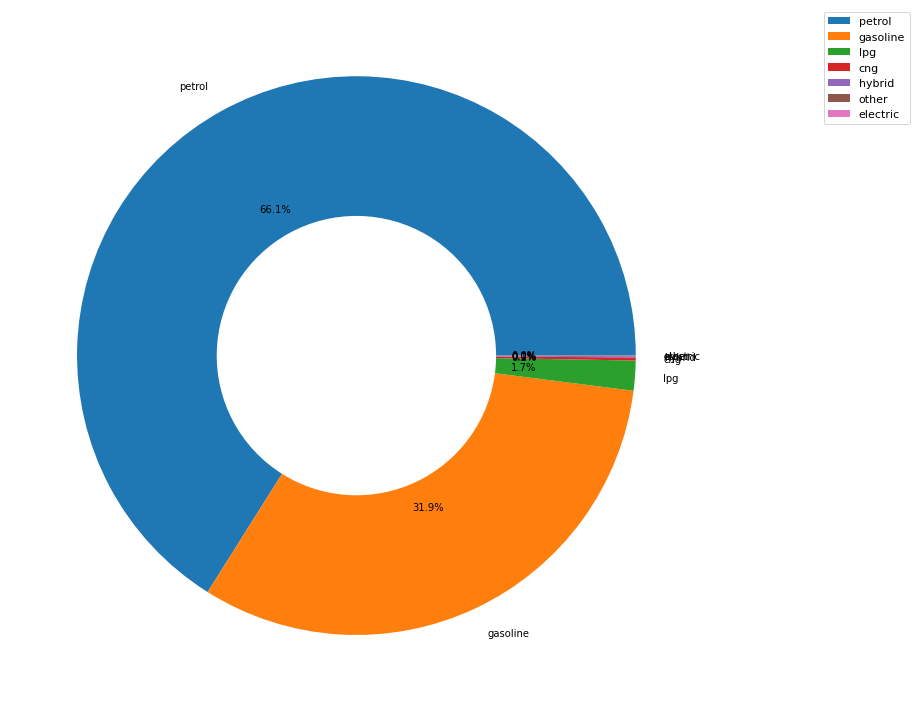

In [22]:
pie_chart(data, 'fuel_type')

Больше всего машин ездит на бензине

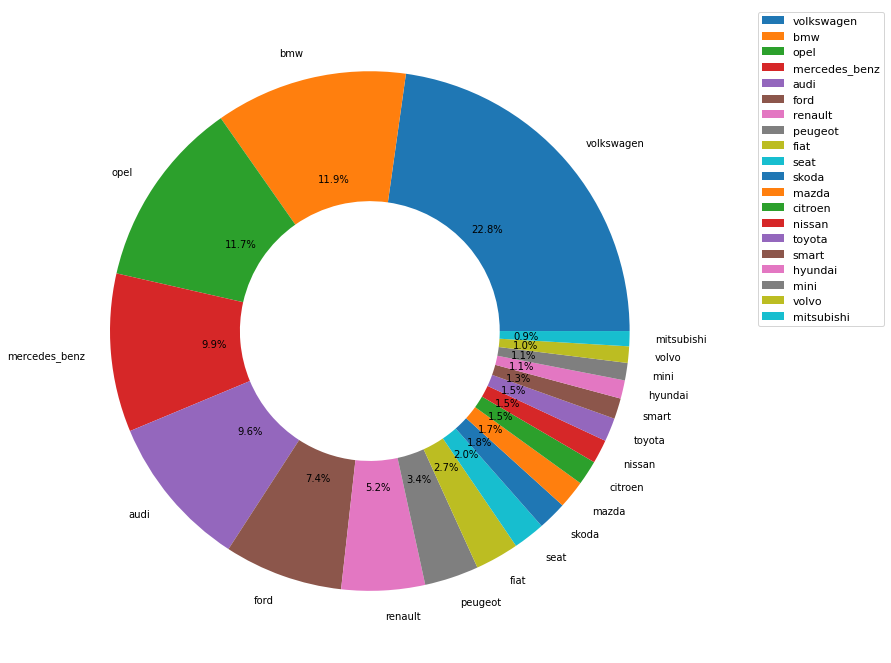

In [23]:
pie_chart(data, 'brand')

Самые популярные марки автомобилей на сервисе:
    
    -volkswagen
    -opel
    -bmw

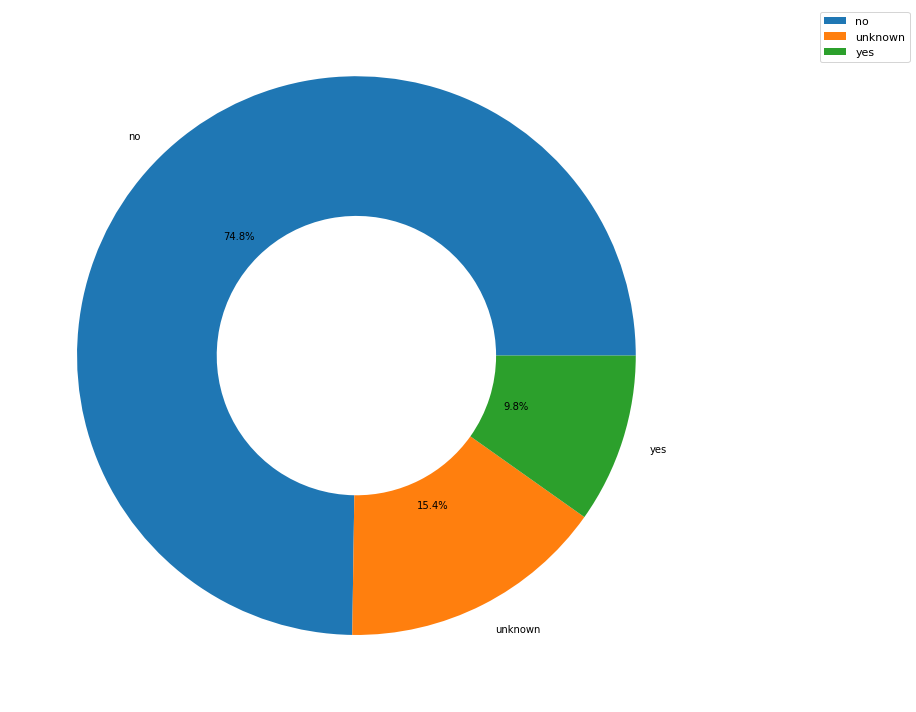

In [24]:
pie_chart(data, 'repaired')

На сервисе большинство машин не были на ремонте - 69.8%

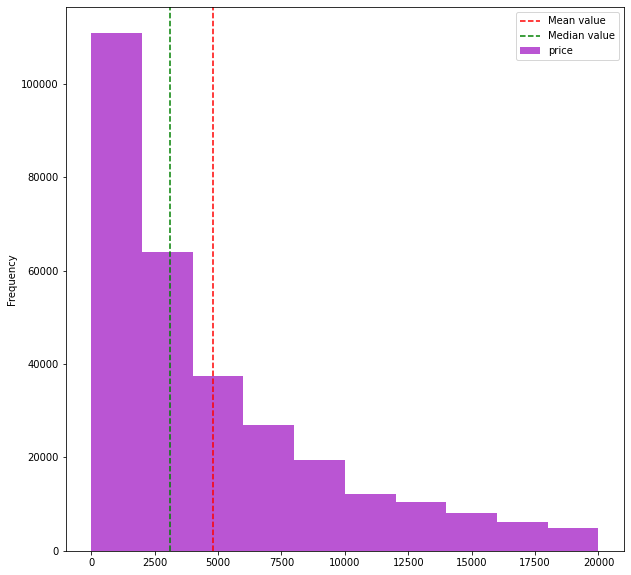

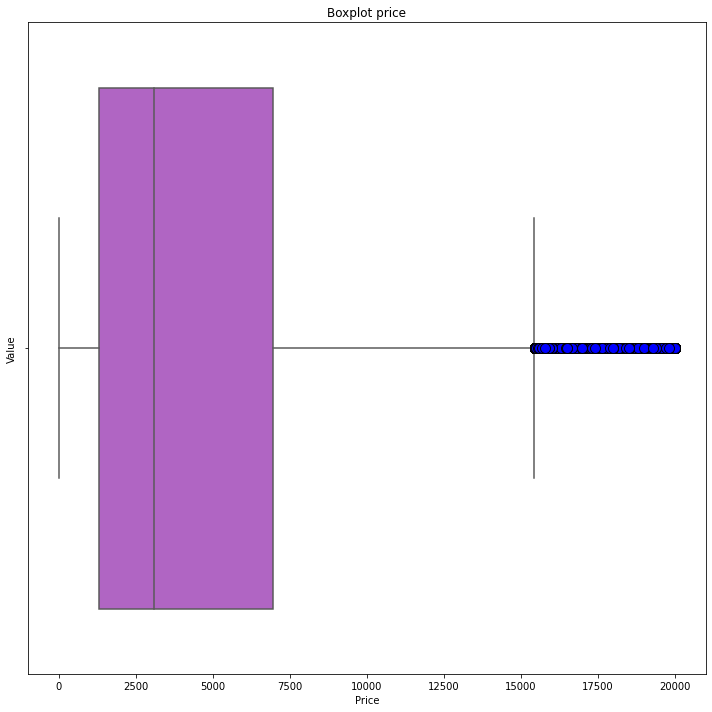

In [25]:
hist_chart(data, 'price')
boxplot_chart(data, 'price', 'Boxplot price', 'Price', 'Value')

Средняя цена автомобиля на сервисе - ~4500 евро, больше всего автомобилей по цене до 2500, по ящику с усами есть выбросы для цена больше ~13000, удалять их не буду, возможно это редкие или просто дорогие машины. Распределение ассиметричное вправо

In [26]:
display(data.registration_year.value_counts())

1999    19052
2005    19032
2006    18601
2000    18440
2003    17860
2004    17822
2001    17483
2002    17001
2007    16136
1998    14997
2008    14533
2009    13845
1997    12008
2010    10383
2011     9594
1996     8706
2017     7468
1995     7008
2012     6939
2016     6381
1994     4000
2013     3991
2018     2867
1993     2845
1992     2527
2014     2405
1991     2282
1990     1861
2015     1071
1989     1031
1988      740
1987      509
1985      425
1986      351
2019       10
Name: registration_year, dtype: int64

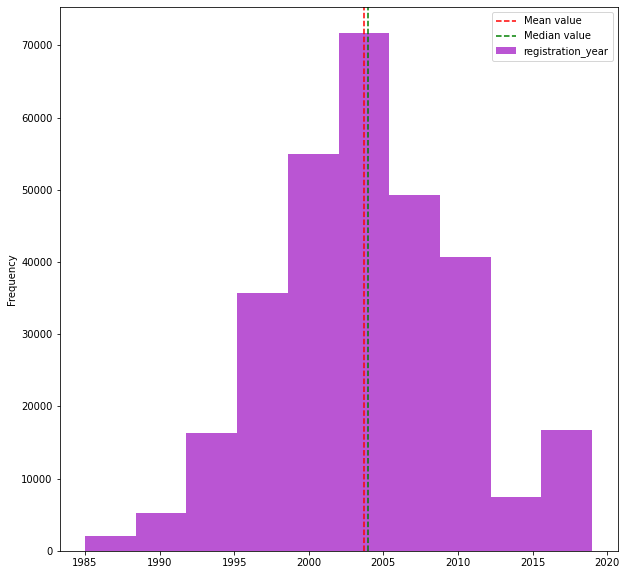

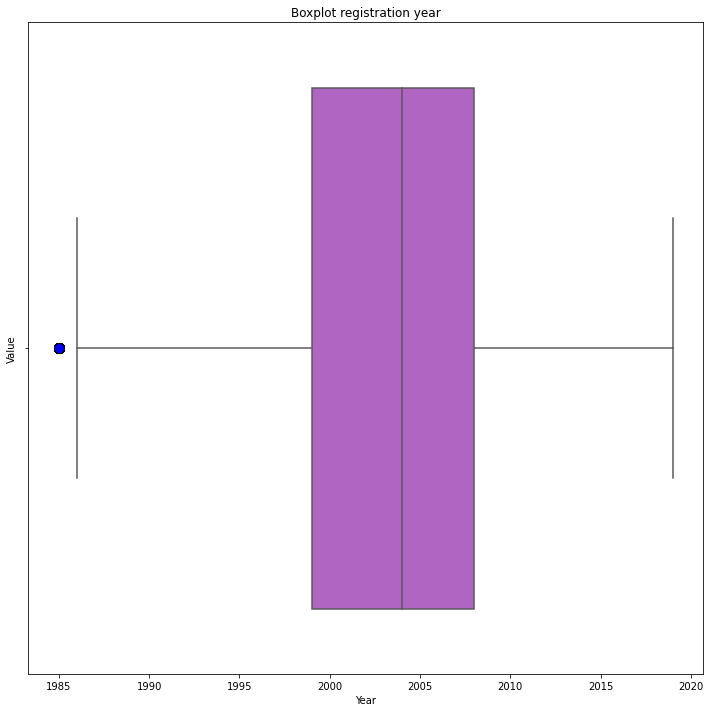

In [27]:
hist_chart(data, 'registration_year')
boxplot_chart(data, 'registration_year', 'Boxplot registration year', 'Year', 'Value')

Больше всего автомобилей зарегистрированы  с 2000 по 2005 годы, распределение нормальное

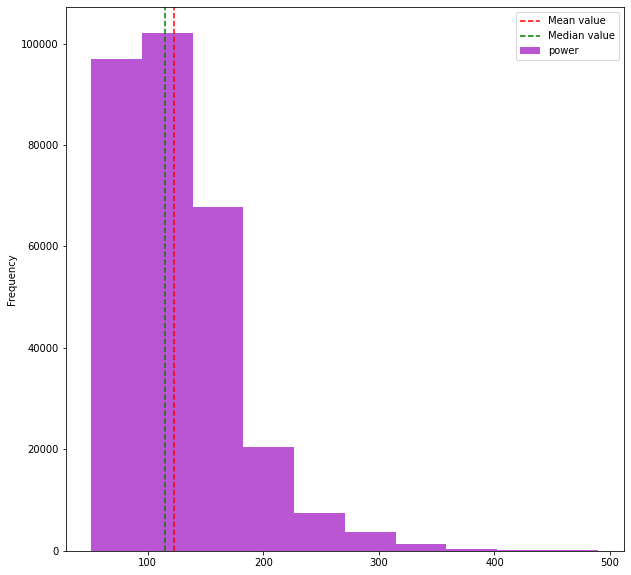

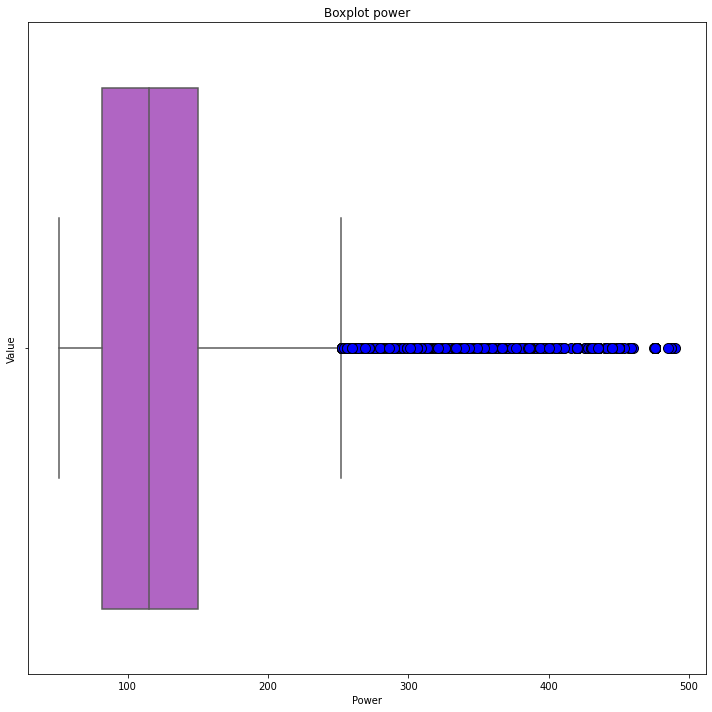

In [28]:
hist_chart(data, 'power')
boxplot_chart(data, 'power', 'Boxplot power', 'Power', 'Value')

На сервисе больше всего автомобилей с мощностью 100-130 л.с., также есть небольшой пик с мощностью до 25 л.с.(P.S. от машин я слишком далек, как будто таких машин и нет, чем объяснить такой пик не знаю, может ли быть такое, что продают там не только машины, а что-то еще, или стоит вообще убрать данные с такой мощностью?). Распределение ассиметрично вправо

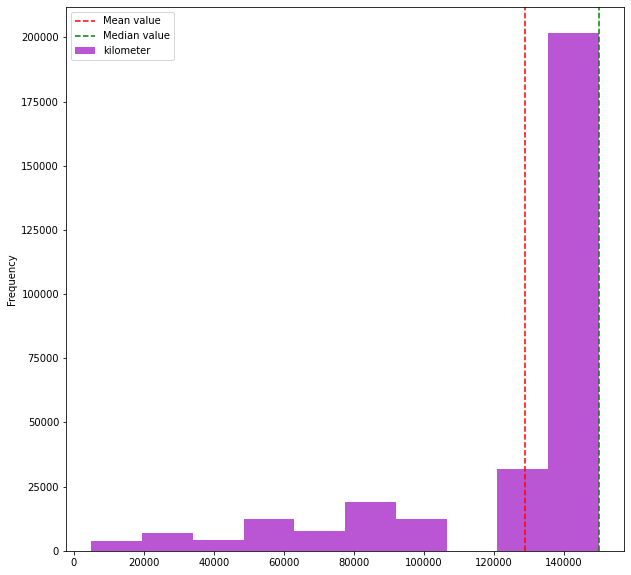

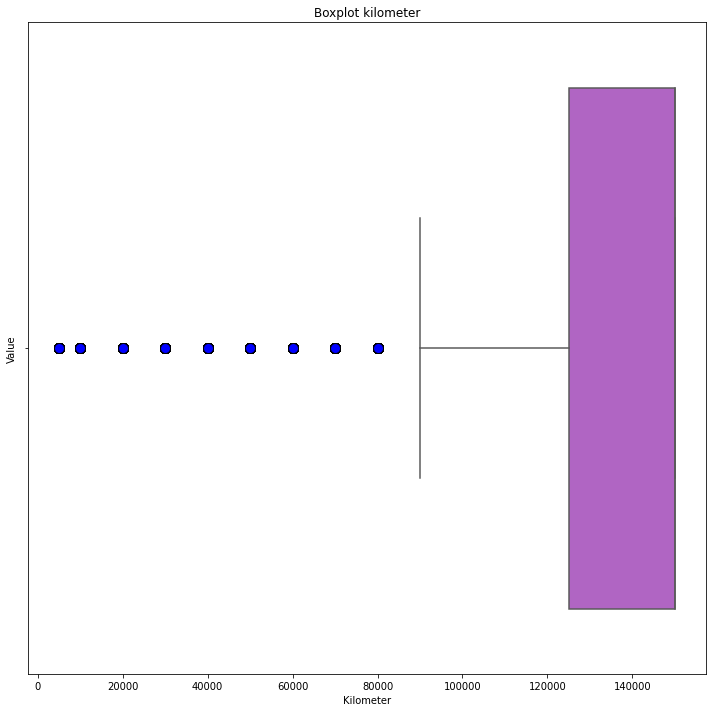

In [29]:
hist_chart(data, 'kilometer')
boxplot_chart(data, 'kilometer', 'Boxplot kilometer', 'Kilometer', 'Value')

Средний пробег у машин ~130000 км., есть выбросы до 90000 км., удалять также их не буду, эти значения могут быть реальными. Распределение ассиметричное влево

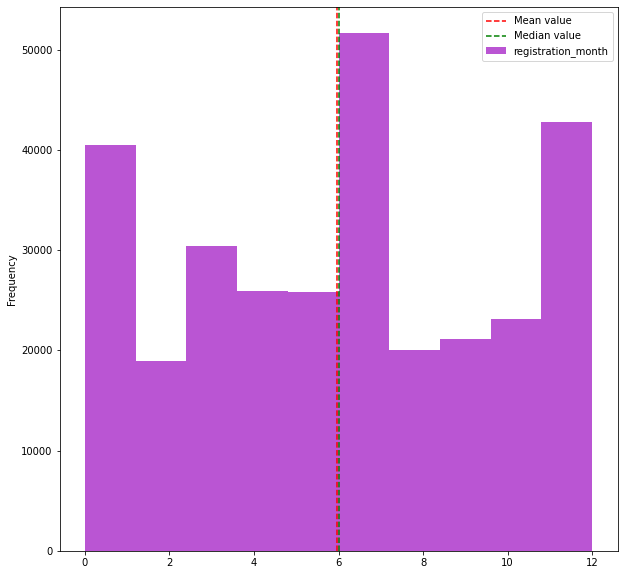

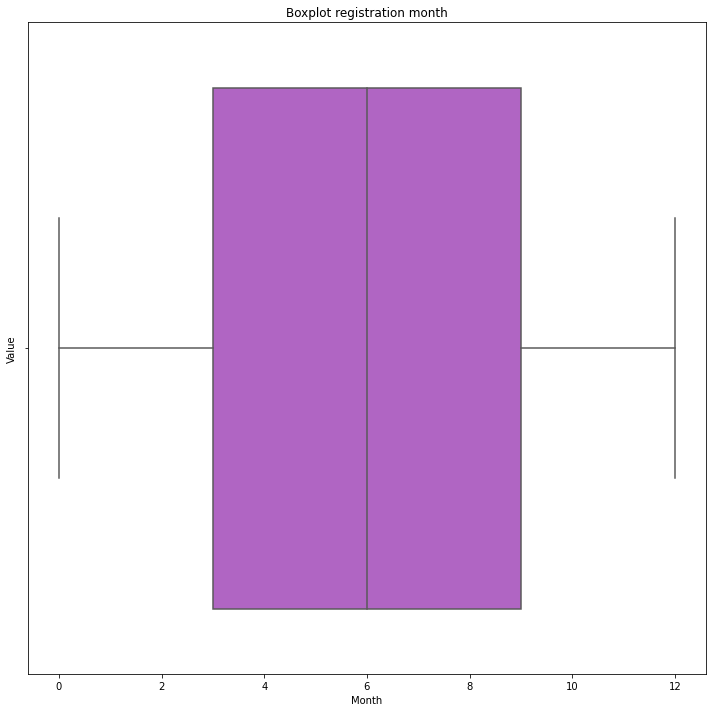

In [30]:
hist_chart(data, 'registration_month')
boxplot_chart(data, 'registration_month', 'Boxplot registration month', 'Month', 'Value')

Чаще всего автомобили зарегестрированы в 1, 6, 12 месяцах, возможно связано с сезонностью

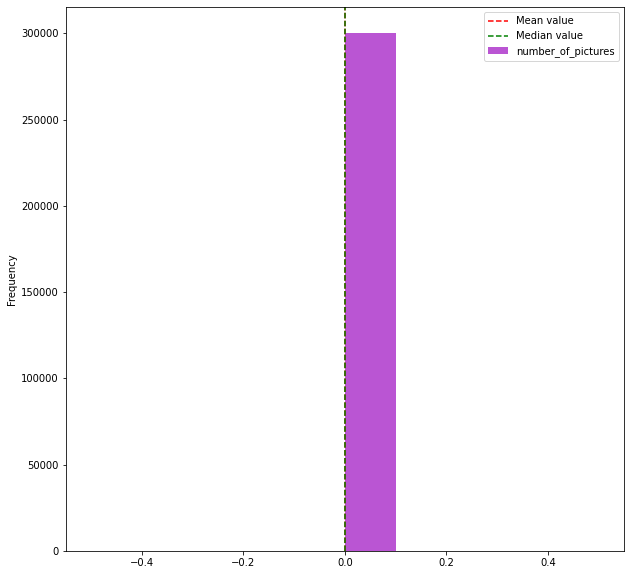

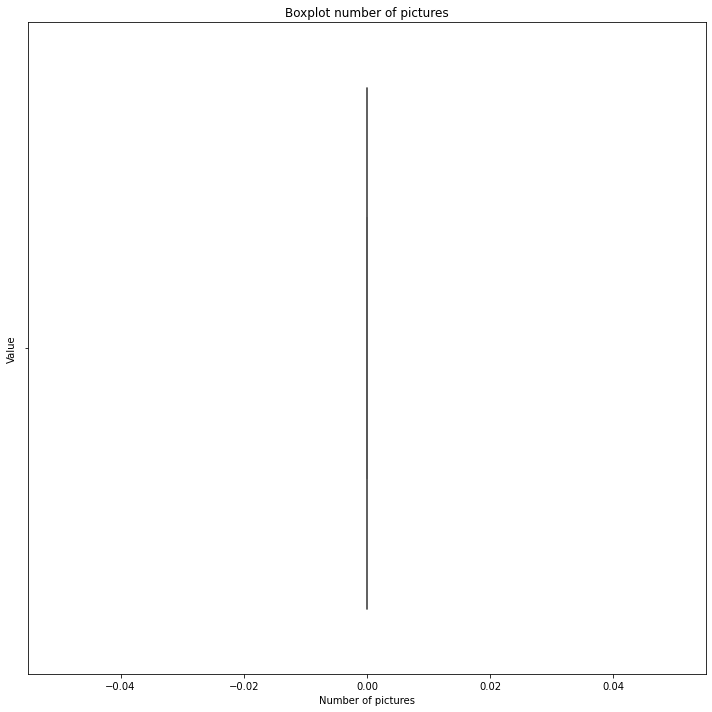

In [31]:
hist_chart(data, 'number_of_pictures')
boxplot_chart(data, 'number_of_pictures', 'Boxplot number of pictures', 'Number of pictures', 'Value')

Из графика видно, что в объявлениях никто не размещает фотографии или же некорректные данные в таблице

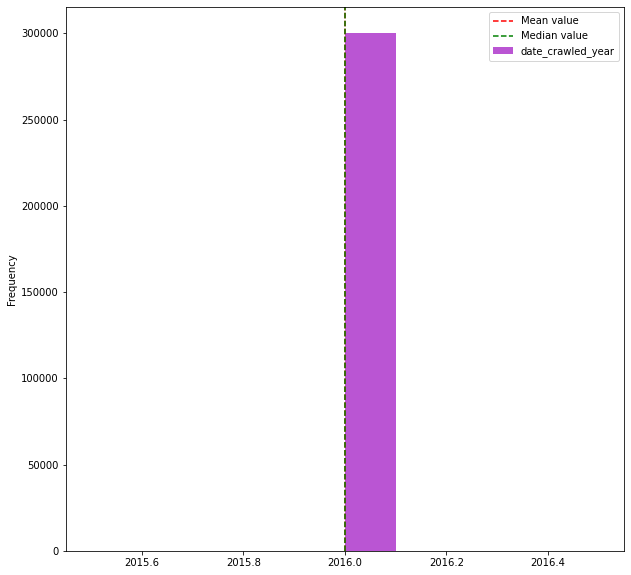

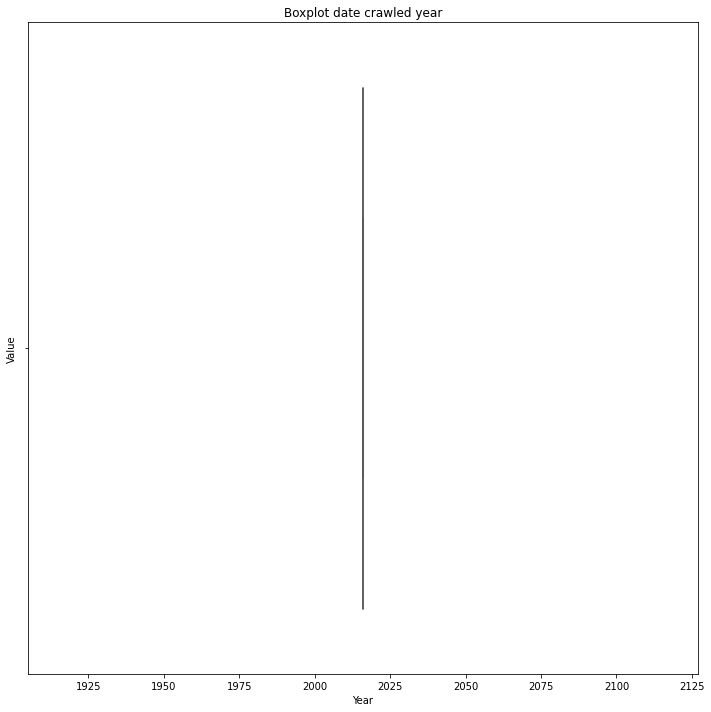

In [32]:
hist_chart(data, 'date_crawled_year')
boxplot_chart(data, 'date_crawled_year', 'Boxplot date crawled year', 'Year', 'Value')

Данные также некорректны

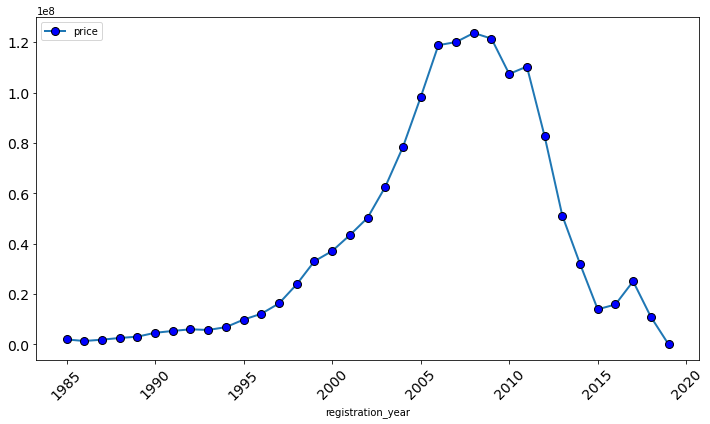

In [33]:
line_chart(data, 'registration_year', 'price', 'sum')

С 2005 по 2010 годы на сервисе продавалось больше всего машин

interval columns not set, guessing: ['registration_year', 'power', 'kilometer', 'registration_month', 'postal_code']


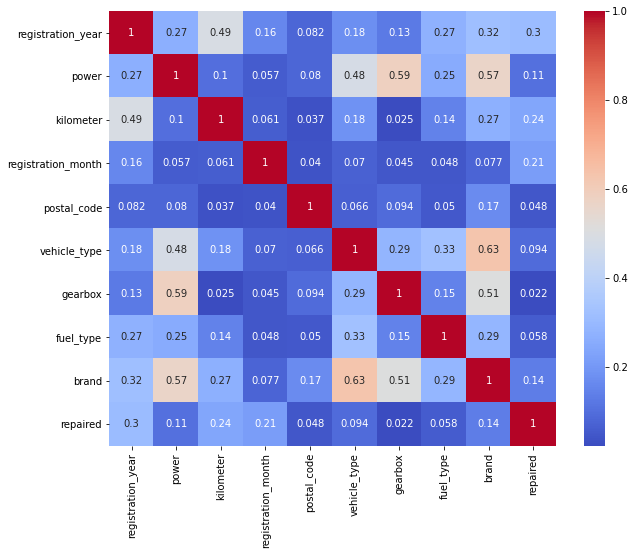

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix(data[[
    'registration_year',
    'power',
    'kilometer',
    'registration_month',
    'postal_code',
    'vehicle_type',
    'gearbox',
    'fuel_type',
    'brand',
    'repaired'
]]), annot=True, cmap='coolwarm')
plt.show()

Выведена матрица корреляций, в ней те признаки, которые будут использоваться для обучения моделей, мультиколлинеарности не наблюдается

## Обучение моделей

In [35]:
num_columns = ['registration_year',
               'power',
               'kilometer',
               'registration_month',
               'postal_code',]
oe_columns = ['vehicle_type',
               'gearbox',
               'fuel_type',
               'brand',
               'repaired']
all_cols = num_columns + oe_columns

Подготовлены столбцы для пайплайна и для обучения

In [36]:
X = data[all_cols]
y = data.price

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

Датасет разделен на выборки

In [38]:
oe_pipe = Pipeline(
    [
        ('simpleImputer_oe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [39]:
data_preprocessor = ColumnTransformer(
    [
        ('oe', oe_pipe, oe_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [40]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(max_depth=39, 
                                 max_features='sqrt', 
                                 min_samples_leaf=2, 
                                 min_samples_split=21, 
                                 random_state=0))
    ]
)

Написан пайплайн для предобработки данных и применения скалера и энкодера

In [41]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

Подготовка данных для обучения модели LightGBM

In [42]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'verbose': 3
}

In [43]:
start_time = time.time()
model = lgb.train(params, train_data, num_boost_round=500)
end_time = time.time()

lead_time = end_time - start_time
print(f"Время обучения: {lead_time} секунд")

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.764465
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.169212
[LightGBM] [Debug] init for col-wise cost 0.004430 seconds, init for row-wise cost 0.092211 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 599
[LightGBM] [Info] Number of data points in the train set: 225153, number of used features: 10
[LightGBM] [Info] Start training from score 4785.867726
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained

In [44]:
start_time = time.time()
X_pred = model.predict(X_train, num_iteration=model.best_iteration)
end_time = time.time()

lead_time = end_time - start_time
print(f"Время предсказания: {lead_time} секунд")

Время предсказания: 8.807461977005005 секунд


In [45]:
cv_scores = cross_val_score(lgb.LGBMRegressor(**params), X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Среднее значение RMSE: {pow(-np.mean(cv_scores), 0.5):.3f}")

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.765537
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.169384
[LightGBM] [Debug] init for col-wise cost 0.004108 seconds, init for row-wise cost 0.093749 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 597
[LightGBM] [Info] Number of data points in the train set: 180122, number of used features: 10
[LightGBM] [Info] Start training from score 4783.583538
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained

Результаты обучения модели LightGBM:

    -Время оубчения - 20.14 секунд
    -Время предсказания - 8.81 секунда
    -Метрика RMSE - 1770.55
    
Я пробовал перебирать гиперпараметры, но результаты оказались только хуже, поэтому подобрал только количество итераций, как итог модель обучилась очень быстро с настройками из коробки и получила метрику RMSE меньше, чем 2500, модель успешно обучилась

In [46]:
param_grid = [
#     {
#         'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
#         'models__n_estimators': [15],
#         'models__max_depth': [20],
#         'preprocessor__num': [StandardScaler(), MinMaxScaler()]
#     }
#     {
#         'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
#         'models__max_depth': range(35, 45),
#         'models__min_samples_split': range(15, 30),
#         'models__min_samples_leaf': range(1, 6),
#         'models__max_features': ['sqrt'],
#     }
]

In [47]:
# grid_search = GridSearchCV(
#     pipe_final,
#     param_grid,
#     cv=2,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,
#     verbose=3
# )
# grid_search.fit(X_train, y_train)

In [48]:
#print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)

In [49]:
# y_pred = grid_search.predict(X_test)
# print(f'Метрика RMSE на тестовой выборке: {mean_squared_error(y_test, y_pred, squared=False).round(3)}')

В гриде подбирал лучшие параметры для моделей и буду использовать их в обучении, для моделей не бустинга я выбрал 

    RandomForestRegressor
    DecisionTreeRegressor
    
Думаю, для такого количества данных они хорошо подходят

In [50]:
start_time = time.time()
pipe_final.fit(X_train, y_train)
end_time = time.time()

lead_time = end_time - start_time
print(f"Время обучения: {lead_time} секунд")

Время обучения: 0.8339686393737793 секунд


In [51]:
start_time = time.time()
y_pred_dtr = pipe_final.predict(X_train)
end_time = time.time()

lead_time = end_time - start_time
print(f"Время предсказания: {lead_time} секунд")

Время предсказания: 0.31748318672180176 секунд


In [52]:
cv_scores = cross_val_score(pipe_final, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Среднее значение RMSE: {pow(-np.mean(cv_scores), 0.5):.3f}")

Среднее значение RMSE: 2047.248


Результаты обучения модели DecisionTreeRegressor:

    -Время оубчения - 4.04 секунды
    -Время предсказания - 0.15 секунды
    -Метрика RMSE - 2028.65
    
Модель справилась успешно с задачей, метрика хуже, чем у LightGBM, но DecisionTreeRegressor обучилась быстрее

In [53]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', RandomForestRegressor(max_depth=20, 
                                 n_estimators=15, 
                                 random_state=0))
    ]
)

In [54]:
start_time = time.time()
pipe_final.fit(X_train, y_train)
end_time = time.time()

lead_time = end_time - start_time
print(f"Время обучения: {lead_time} секунд")

Время обучения: 12.405692100524902 секунд


In [55]:
start_time = time.time()
y_pred_rfr = pipe_final.predict(X_train)
end_time = time.time()

lead_time = end_time - start_time
print(f"Время предсказания: {lead_time} секунд")

Время предсказания: 1.352459192276001 секунд


In [56]:
cv_scores = cross_val_score(pipe_final, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Среднее значение RMSE: {pow(-np.mean(cv_scores), 0.5):.3f}")

Среднее значение RMSE: 1747.697


Результаты обучения модели RandomForestRegressor:

    -Время оубчения - 391.92 секунды
    -Время предсказания - 0.44 секунды
    -Метрика RMSE - 1747.34
    
Модель справилась успешно с задачей, метрика почти такая же, как у LightGBM, но RandomForestRegressor обучилась намного медленнее 

## Анализ моделей

In [57]:
start_time = time.time()
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
end_time = time.time()

lead_time = end_time - start_time
print(f"Время предсказания: {lead_time} секунд")

Время предсказания: 2.899092197418213 секунд


In [58]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

RMSE: 1682.4031821162246


***Итоги обучения трех моделей***:

    Результаты обучения модели LightGBM:

        -Время оубчения - 20.14 секунд
        -Время предсказания - 8.81 секунда
        -Метрика RMSE - 1770.55
        
    Результаты обучения модели DecisionTreeRegressor:

        -Время оубчения - 4.04 секунды
        -Время предсказания - 0.15 секунды
        -Метрика RMSE - 2028.65
        
    Результаты обучения модели RandomForestRegressor:

        -Время оубчения - 391.92 секунды
        -Время предсказания - 0.44 секунды
        -Метрика RMSE - 1747.34
        
    Результаты обучения модели LightGBM(тестовая выборка):
    
        -Время предсказания - 2.99 секунда
        -Метрика RMSE - 1682.55
        
Думаю самый важный критерий все-таки это метрика RMSE, а потом уже время обучения и предсказания, сервису по продаже автомобилей я рекомендую выбрать модель градиентного бустинга LightGBM, метрика у нее высокая - 1770, но самое главное отличие от моделей DecisionTreeRegressor и RandomForestRegressor, в том что лучше всего она сработала с настройками из коробки, для моделей не бустинга требуется перебор гиперпараметров, который длится достаточно долго